## FFT 1D with a regular square phase patttern

 author : Sylvie Dagoret-Campagne
- aflilation IJCLab/IN2P3/CNRS
- creation date 2025-01-14
- last update : 2025-01-14 : Compare aperture and aperture + diffractive pattern + transmission efficiency
- doc on FFT : https://numpy.org/doc/2.0/reference/generated/numpy.fft.fft.html
- conda environnement : poppy_conda_py312 (on my macbook)
- install poppy : https://poppy-optics.readthedocs.io/en/latest/
- install rise in jupyterlab to see the slides : https://github.com/jupyterlab-contrib/rise
- install pandoc for documentation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.integrate import quad

In [2]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['axes.titlesize'] =  24
mpl.rcParams['axes.labelsize'] =  20
mpl.rcParams['lines.markersize'] =  10
mpl.rcParams['xtick.labelsize'] =  16
mpl.rcParams['ytick.labelsize'] = 16

## Introduction

### Diffraction of a parallel beam by a 1D aperture $x_1$ seen on a screen at $x_0$ 

We approximate the diffraction by an optical element with the 1D approximation, with the $x$ axis as the transverse coordinalte and the $z$ axis the wave propagation axis.
Taking the formula from the Goodman book we get the formula:

- in Fresnel approximation (spherical wave $\rightarrow$ quadratic terms in propagation term $\frac{e^{ikr_{01}}}{j\lambda z}$~:$z^3 \gg \frac{\pi}{4\lambda}\left(x_0-x_1\right)^4|_{max} $:
$$
U(x_0) = \frac{exp(jkz)}{jkz} \exp\left(j \frac{k}{2z}x_0^2 \right) \int \int \left\{ U(x_1) \exp\left(  j \frac{k}{2z}x_1^2\right)\right\} \times \exp \left\{ -j \frac{2 \pi}{\lambda z}x_0\cdot x_1
\right\}dx_1 
$$
- in Fraunhofer approximation $ z \gg \frac{k(x_1^2+y_1)}{2}|_{max}$:
$$
U(x_0) = \frac{exp(jkz)}{jkz} \exp\left(j \frac{k}{2z}x_0^2 \right) \int \int  U(x_1)  \times \exp \left\{ -j \frac{2 \pi}{\lambda z}x_0\cdot x_1
\right\}dx_1 
$$
- The Fraunhofer approximation solution is proportional to the Fourier transform of $U(x_1)$ at frequency $f_X = \frac{x_0}{\lambda z} = \frac{\tan \alpha}{\lambda }$
- The Fresnel approximation solution is proportional to the Fourier transform of $\left \{ U(x_1) \cdot \exp\left(  j \frac{k}{2z}x_1^2\right) \right\}$ at frequency $f_X = \frac{x_0}{\lambda z} = \frac{\tan \alpha}{\lambda }$
- $ \alpha$ is the incident angle on the focal line  in the $(X-Z)$ plane.

### Transform the parallel beam into a converging beam

- thin lens of focal length $\phi$ with a transmission function (depending on lens depth $\Delta_0$ and refractive index $n$):
$$
U_l(x) = \exp(j k\Delta_0 n) \cdot \exp(-j \frac{k}{2\phi}x^2)
$$
- When a lens (or mirror) transform a parallel beam into a converging beam at the location of an object and have a screen at the focal plane, the $\exp \left(j \frac{k}{2z}x_1^2 \right)$ is compensated by the lens term $\exp(-j \frac{k}{2\phi}x^2)$
- Thus a  converging lens (or mirror) transform a parallel beam Fresnel diffraction into a Fraunhofer diffraction, provided $z=\phi$.
$$
U(x_\phi) = \frac{exp(jk\phi)}{jk\phi} \exp\left(j \frac{k}{2\phi}x_{\phi}^2 \right) \int \int U(x)\cdot P(x) \times \exp 
\left\{ -j \frac{2 \pi}{\lambda \phi}x_\phi x\right\} dx 
$$

### The pupil function of the lens
$$
P(x) = \left\{ \begin{array}{c} 1 \;\; r < D/2 \\ 0 \;\;r > D/2 \end{array} \right.
$$

where $r=|x|$ and $D$ is the lens diameter.

## Function tools

In [3]:
def convert_angle_to_0_2pi_interval(angle):
    new_angle = np.arctan2(np.sin(angle), np.cos(angle))
    new_angle = np.where(new_angle < 0,np.abs(new_angle) + 2 * (np.pi - np.abs(new_angle)),new_angle)
    return new_angle

In [4]:
convert_angle_to_0_2pi_interval(-np.pi/4)

array(5.49778714)

In [5]:
def convert_angle_to_mpi_ppi_interval(angle):
    new_angle = convert_angle_to_0_2pi_interval(angle)
    new_angle = np.where(new_angle > np.pi, new_angle - 2*np.pi,new_angle)

    return new_angle

### Auxtel Configuration

In [6]:
# wavelength in m
wl = 0.5e-6
# pixel scale
# 10 microns pixel , 105 microns per arcsec
pix_scale = 10.0/105.0 # arcsec per pixel
fov_arcsec = 5.0 # must restrict the FOV in focl plane to avoid aliasing
# diameter in m
D = 1.2
Fnum = 18
# focal length
FL = D*Fnum
# Dccd
Dccd = 180e-3
# beam radius at object positon
beam_radius_m =  D/2/FL*Dccd
beam_radius_mm =  D/2/FL*Dccd*1000

In [7]:
beam_radius_mm

5.0

### Diffraction Pattern

In [8]:
Neff = 150
xmin = -0.05
xmax = 0.05
dxt = xmax-xmin
a = 1/Neff

## Transmission functions

In [9]:
def set_beam_aperture(x,radius = beam_radius_mm):
    """
    """
    a = np.where(np.logical_or(x<-radius,x>radius),0.,1.)
    return a

In [10]:
def set_ronchi_transmission_debug(x,opticalelement_nblines_permm=Neff):
    """
    Generate a square pattern of transmission.
    x in mm
    """
    a = 1/opticalelement_nblines_permm
    return np.rint(x/a-0.25 - np.floor(x/a-0.25))

Text(0.5, 0, 'mm')

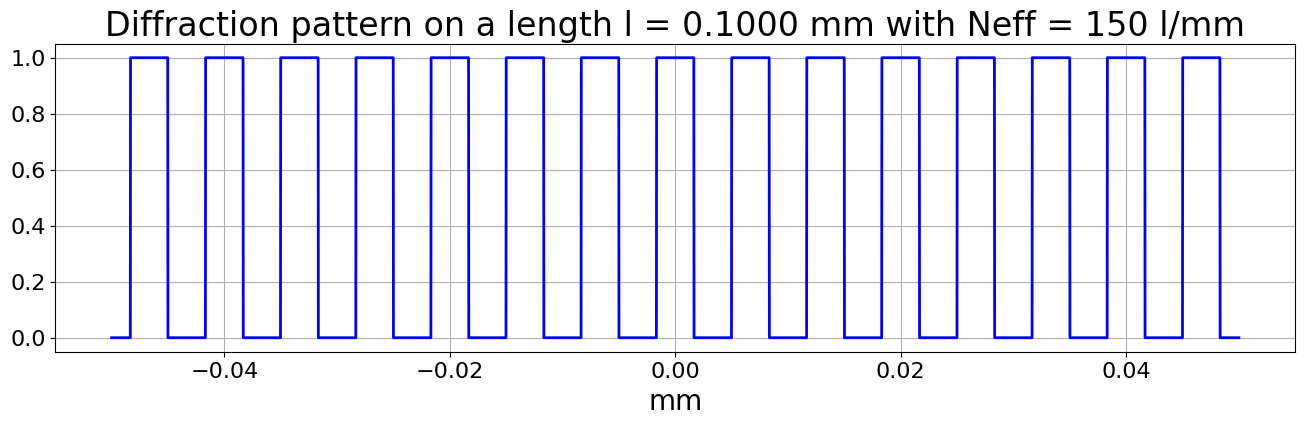

In [11]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
x = np.linspace(-.05,0.05,5000)
y = set_ronchi_transmission_debug(x)
ax.plot(x,y,'b-')
ax.grid()
ax.set_title(f"Diffraction pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax.set_xlabel("mm")

### Parameters of the FFT

In [12]:
Nb = 10001
padding_factor = 1.5

In [13]:
# x in units of mm
xe = np.linspace(-beam_radius_mm*padding_factor,+beam_radius_mm*padding_factor,Nb)
dxe = np.diff(xe).mean()
fe = 1/dxe
fmax = fe/2

In [14]:
print(f"Sampling distance dxe = {dxe} mm ")
print(f"Sampling frequency fe = {fe:.3f} mm -1")
print(f"Max signal requency fmax = {fmax:.3f} mm -1 before aliasing")
print(f"Beam radius = {beam_radius_mm} mm")
print(f"Beam radius frequency = {1/beam_radius_mm} mm-1")

Sampling distance dxe = 0.0015 mm 
Sampling frequency fe = 666.667 mm -1
Max signal requency fmax = 333.333 mm -1 before aliasing
Beam radius = 5.0 mm
Beam radius frequency = 0.2 mm-1


## Compute inputs for the FFT

### Input for the aperture

In [15]:
ap = set_beam_aperture(xe)

### Input for the pattern

In [16]:
ye = set_ronchi_transmission_debug(xe)
# set padding on the borders
r = np.where(np.logical_or(xe<-beam_radius_mm,xe>beam_radius_mm),0,ye)

## Plots the patterns

### Aperture pattern

Text(0.5, 0, 'mm')

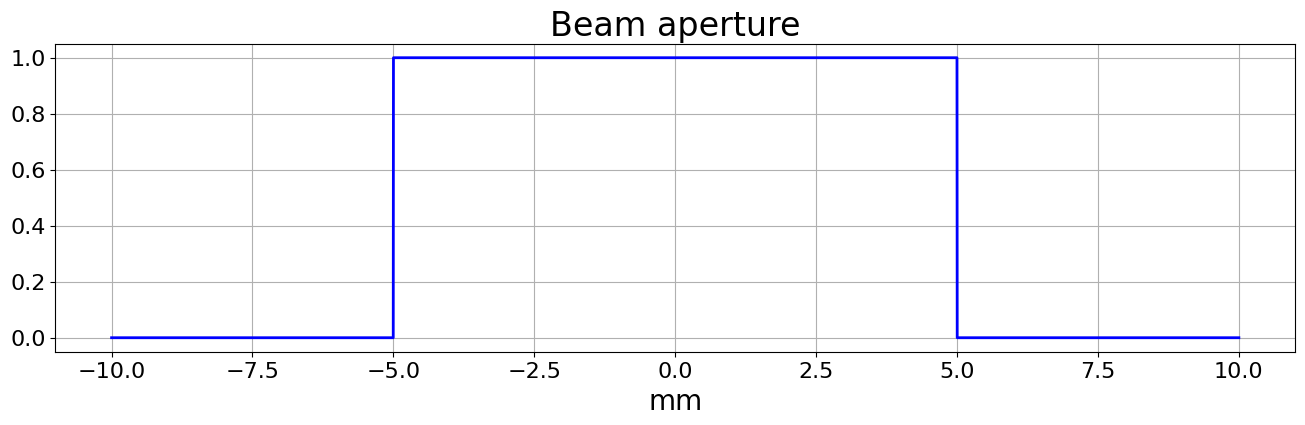

In [17]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
x = np.linspace(-10.,10.,5000)
y = set_beam_aperture(x)
ax.plot(x,y,'b-')
ax.grid()
ax.set_title(f"Beam aperture")
ax.set_xlabel("mm")

### Plot the transmission pattern

Text(0.5, 0, 'mm')

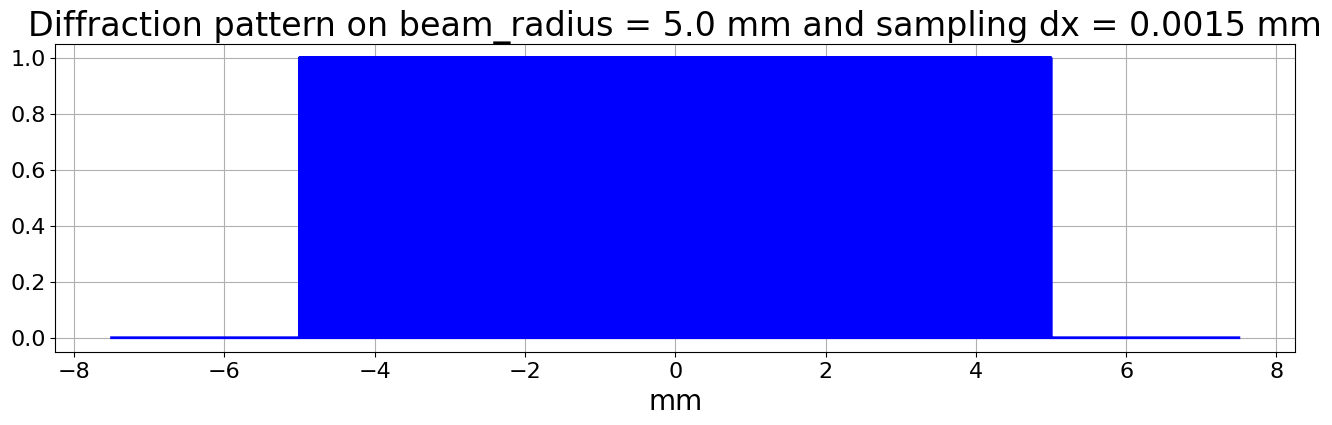

In [18]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(xe,r,'b-')
ax.grid()
ax.set_title(f"Diffraction pattern on beam_radius = {beam_radius_mm} mm and sampling dx = {dxe:.4f} mm")
ax.set_xlabel("mm")

## Compute the FFT

### FFT for the beam with the aperture only

In [19]:
spa = np.fft.fft(ap)
# the frequency in units of mm^-1

# do a deep copy
freqa = np.array(np.fft.fftfreq(ap.shape[-1], d=dxe))
reala = np.array(spa.real)
imaga = np.array(spa.imag)
modulea = np.array(np.abs(spa))
phasea = np.array(np.angle(spa))

In [20]:
freqa = np.fft.fftshift(freqa)
reala = np.fft.fftshift(reala)
imaga = np.fft.fftshift(imaga)
modulea = np.fft.fftshift(modulea)
phasea = np.fft.fftshift(phasea)
N = len(freqa)

#### Plot FFT components
- a) real part
- b) imaginary part
- c) module
- d) phase

Text(0, 0.5, 'FFT phase')

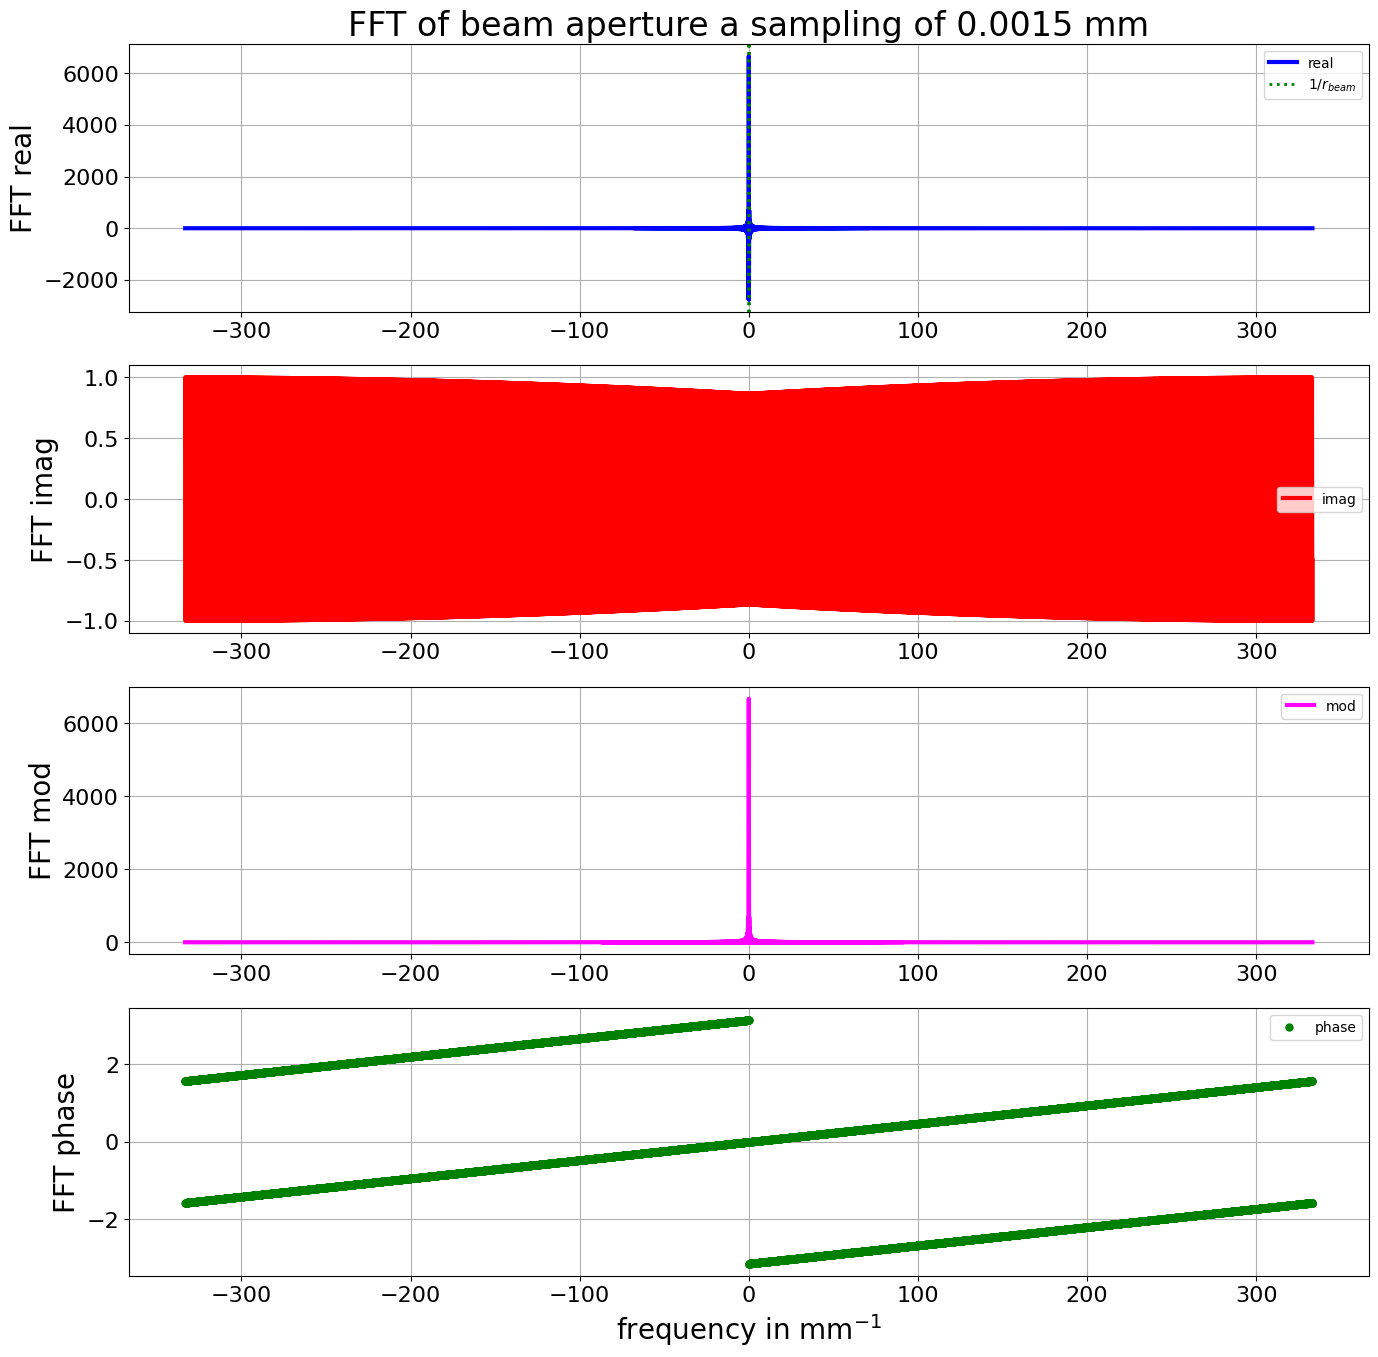

In [21]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(16,16),sharex=False)
ax1.plot(freqa, reala, 'b',lw=3, label = "real")
ax1.grid()
ax1.set_title(f"FFT of beam aperture a sampling of {dxe:.4f} mm")
ax1.axvline(x=1/beam_radius_mm,c="g",ls=":",label="$1/r_{beam}$")
ax1.axvline(x=-1/beam_radius_mm,c="g",ls=":")
ax2.plot(freqa, imaga, 'r',lw=3, label = "imag")
ax2.grid()
ax3.plot(freqa, modulea, c='magenta',lw=3, label = "mod")
ax3.grid()
ax4.plot(freqa, convert_angle_to_mpi_ppi_interval(phasea),'.g',lw=3, label = "phase")
ax4.grid()
ax4.set_xlabel("frequency in mm$^{-1}$")
ax1.legend()
ax1.set_ylabel("FFT real")
ax2.legend()
ax2.set_ylabel("FFT imag")
ax3.legend()
ax3.set_ylabel("FFT mod")
ax4.legend()
ax4.set_ylabel("FFT phase")

#### Plot the FFT coefficients in the aperture diffractive region

In [22]:
print(f"Beam radius = {beam_radius_mm} mm")
print(f"Beam radius frequency = {1/beam_radius_mm} mm-1")

Beam radius = 5.0 mm
Beam radius frequency = 0.2 mm-1


Text(0.5, 1.0, 'First Fourier components')

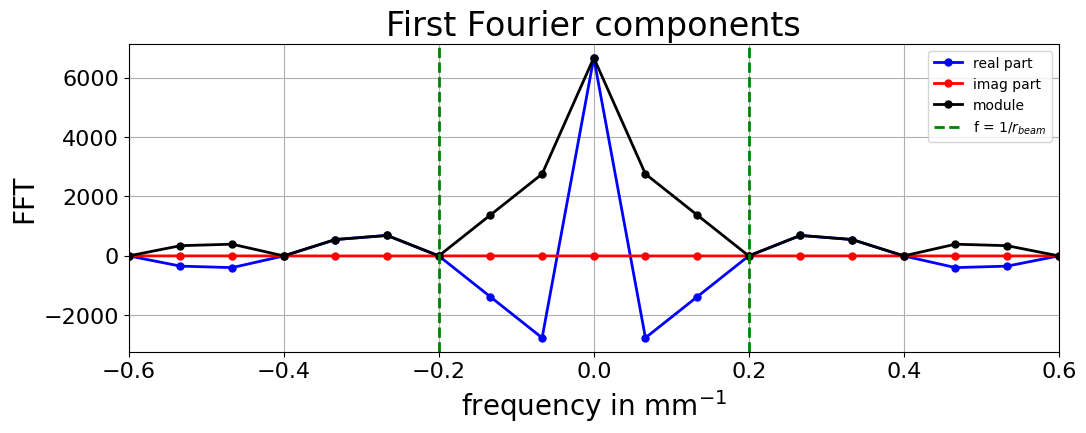

In [23]:
fig,ax = plt.subplots(1,1,figsize=(12,4))

DF = 3*1/beam_radius_mm

ax.plot(freqa,reala,marker=".",c="b",label="real part")
ax.plot(freqa,imaga,marker=".",c="r",label="imag part")
ax.plot(freqa,modulea,marker=".",c="k",label="module")
ax.set_ylabel("FFT")
ax.set_xlim(-DF,DF)

ax.set_xlabel("frequency in mm$^{-1}$")
ax.axvline(x=1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax.grid()
ax.legend()
ax.set_title("First Fourier components")

#### First Fourier components 

Text(0.5, 0.98, 'First coefficients of FFT for beam aperture')

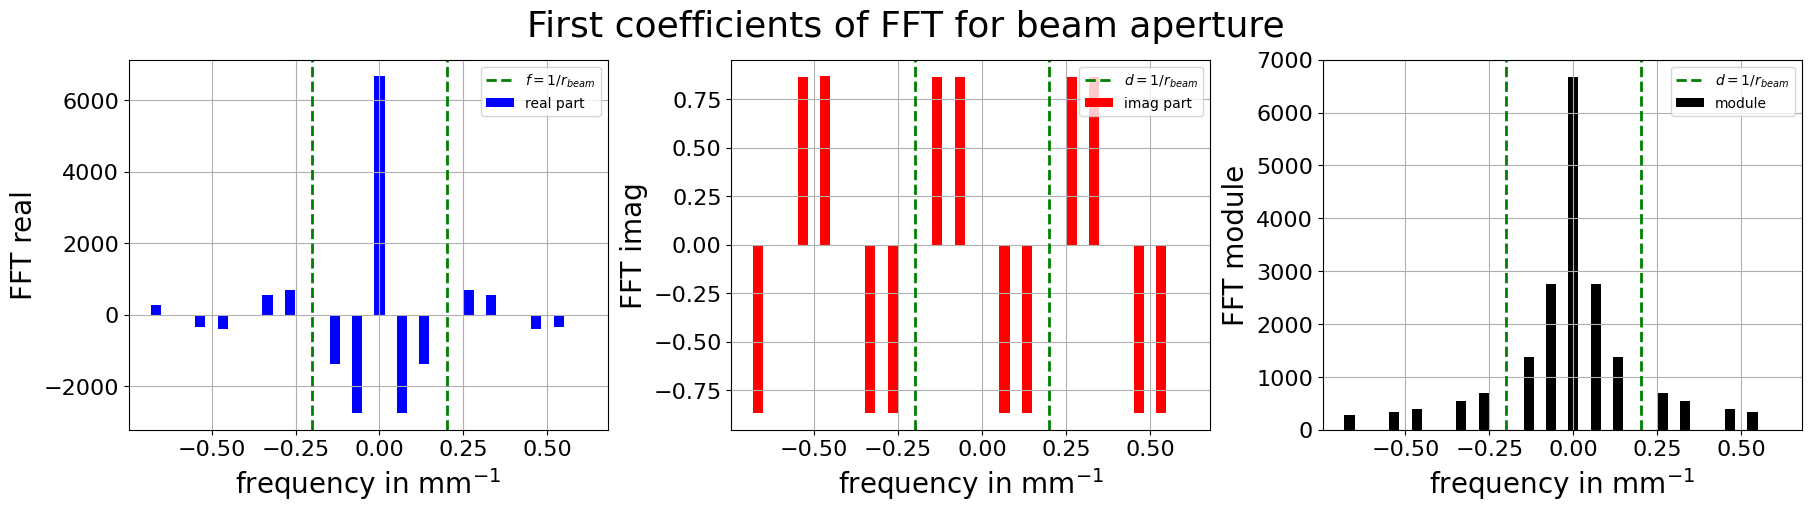

In [24]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5),sharex=True,layout="constrained")
ax1.bar(freqa[N//2-10:N//2+10],reala[N//2-10:N//2+10],width=0.03,facecolor="b",label="real part")
ax2.bar(freqa[N//2-10:N//2+10],imaga[N//2-10:N//2+10],width=0.03,facecolor="r",label="imag part")
ax3.bar(freqa[N//2-10:N//2+10],modulea[N//2-10:N//2+10],width=0.03,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")
ax1.axvline(x=1/beam_radius_mm,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle("First coefficients of FFT for beam aperture",fontsize=26)

### FFT for the beam with the optical element in place : Phase

In order that the two level of $ye$ to be in opposite phase, we must have
- $phase = \pi$ when ye =1
- $phase = 0$ when ye =0

In [25]:
r = ap*np.exp(1j*np.pi*ye)

In [26]:
sp = np.fft.fft(r)
# the frequency in units of mm^-1
# do a deep copy
freq = np.array(np.fft.fftfreq(r.shape[-1], d=dxe))
real = np.array(sp.real)
imag = np.array(sp.imag)
module = np.array(np.abs(sp))
phase = np.array(np.angle(sp))

In [27]:
freq = np.fft.fftshift(freq)
real = np.fft.fftshift(real)
imag = np.fft.fftshift(imag)
module = np.fft.fftshift(module)
phase = np.fft.fftshift(phase)
N = len(freq)

### Order 1 and order 2 components

In [28]:
# compute the spatial frequency where the order 1 and 2 are
f_order1 = Neff
f_order2 = 2*Neff

In [29]:
def plot_orders_regions(ax,df=1/beam_radius_mm):
    """
    
    """

    ax.axvline(x=df,c="pink",ls=":",label="order 0")
    ax.axvline(x=-df,c="pink",ls=":")

    if f_order1 < fmax:
        ax.axvline(x=f_order1+df,ls = ":",color="purple",label="order 1")
        ax.axvline(x=f_order1-df,ls = ":",color="purple")
        ax.axvline(x=-f_order1-df,ls = ":",color="purple")
        ax.axvline(x=-f_order1+df,ls = ":",color="purple")
       
    if f_order2 < fmax:
        ax.axvline(x=f_order2+df,ls = ":",color="cyan",label="order 2")
        ax.axvline(x=f_order2-df,ls = ":",color="cyan")
        ax.axvline(x= - f_order2-df,ls = ":",color="cyan")
        ax.axvline(x= - f_order2+df,ls = ":",color="cyan")

#### Plot FFT components
- a) real part
- b) imaginary part
- c) module
- d) phase

Text(0, 0.5, 'FFT phase')

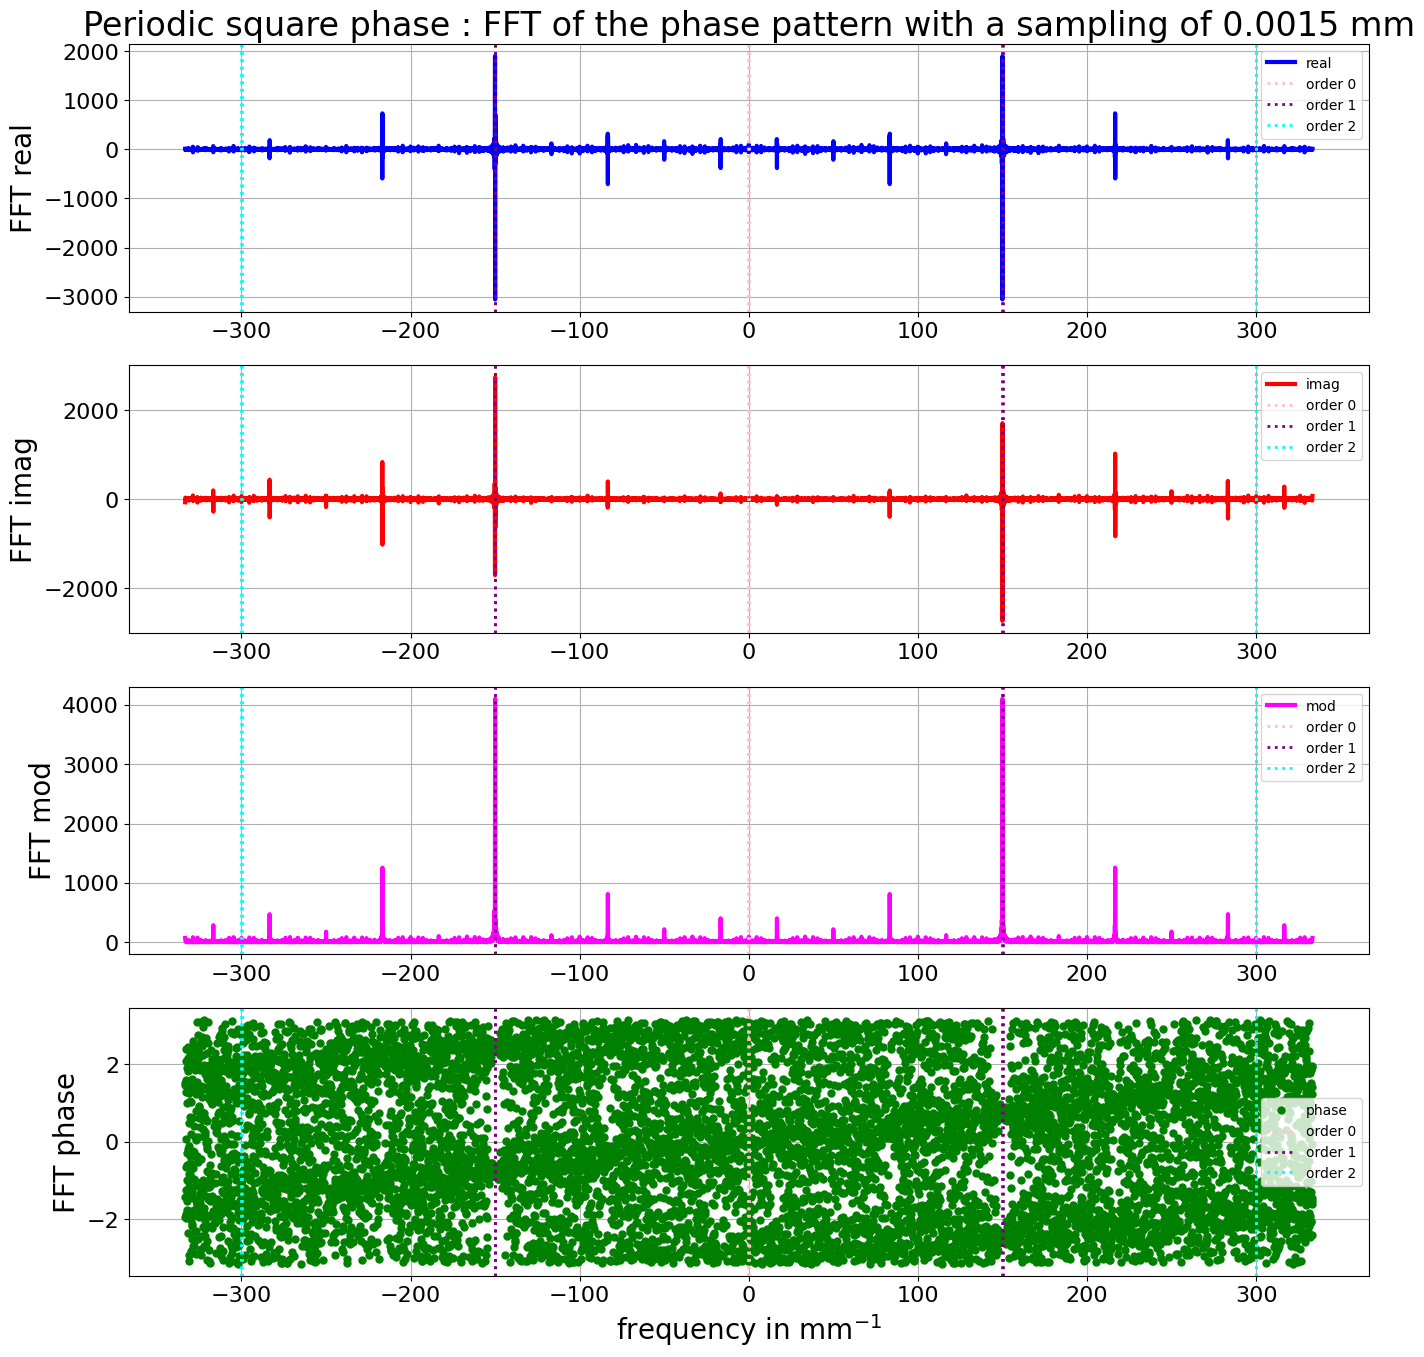

In [30]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(16,16),sharex=False)

ax1.plot(freq, real, 'b',lw=3, label = "real")
ax1.grid()
ax1.set_title(f"Periodic square phase : FFT of the phase pattern with a sampling of {dxe:.4f} mm")
plot_orders_regions(ax1)

ax2.plot(freq, imag, 'r',lw=3, label = "imag")
plot_orders_regions(ax2)
ax2.grid()

ax3.plot(freq, module, c='magenta',lw=3, label = "mod")
plot_orders_regions(ax3)
ax3.grid()

ax4.plot(freq, convert_angle_to_mpi_ppi_interval(phase),'.g',lw=3, label = "phase")
plot_orders_regions(ax4)
ax4.grid()
ax4.set_xlabel("frequency in mm$^{-1}$")


ax1.legend()
ax1.set_ylabel("FFT real")
ax2.legend()
ax2.set_ylabel("FFT imag")
ax3.legend()
ax3.set_ylabel("FFT mod")
ax4.legend()
ax4.set_ylabel("FFT phase")

#### Plot the FFT coefficients in the aperture diffractive region

In [31]:
print(f"Beam radius = {beam_radius_mm} mm")
print(f"Beam radius frequency = {1/beam_radius_mm} mm-1")

Beam radius = 5.0 mm
Beam radius frequency = 0.2 mm-1


In the following plot, we see almost zero imaginary part due to the fact the function is pair.

In [ ]:
fig,(ax1,ax2,ax3)  = plt.subplots(3,1,figsize=(12,12),layout="constrained")

DF = 3*1/beam_radius_mm

ax1.plot(freq,real,marker=".",c="b",label="real part")
ax1.plot(freq,imag,marker=".",c="r",label="imag part")
ax1.plot(freq,module,marker="o",c="k",label="module")
ax1.set_ylabel("FFT")
ax1.set_xlim(-DF,DF)

ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.axvline(x=1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax1.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax1.grid()
ax1.legend()
ax1.set_title("Periodic square Phase : First Fourier components (order 0)")


ax2.plot(freq,real,marker=".",c="b",label="real part")
ax2.plot(freq,imag,marker=".",c="r",label="imag part")
ax2.plot(freq,module,marker="o",c="k",label="module")
ax2.set_ylabel("FFT")
ax2.set_xlim( f_order1 -DF , f_order1+ DF)

ax2.set_xlabel("frequency in mm$^{-1}$")
ax2.axvline(x=f_order1 + 1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax2.axvline(x=f_order1 -1/beam_radius_mm,c="g",ls="--")
ax2.grid()
ax2.legend()
ax2.set_title("Periodic square Phase : First Fourier components (order +1)")


ax3.plot(freq,real,marker=".",c="b",label="real part")
ax3.plot(freq,imag,marker=".",c="r",label="imag part")
ax3.plot(freq,module,marker="o",c="k",label="module")
ax3.set_ylabel("FFT")
ax3.set_xlim( -f_order1 -DF , -f_order1+ DF)

ax3.set_xlabel("frequency in mm$^{-1}$")
ax3.axvline(x=-f_order1 + 1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax3.axvline(x=-f_order1 -1/beam_radius_mm,c="g",ls="--")
ax3.grid()
ax3.legend()
ax3.set_title("Periodic square Phase : First Fourier components (order -1)")



Text(0.5, 1.0, 'Periodic square Phase : First Fourier components (order -1)')

#### First Fourier components 

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5),sharex=True,layout="constrained")

ax1.bar(freq[N//2-10:N//2+10],real[N//2-10:N//2+10],width=0.03,facecolor="b",label="real part")
ax2.bar(freq[N//2-10:N//2+10],imag[N//2-10:N//2+10],width=0.03,facecolor="r",label="imag part")
ax3.bar(freq[N//2-10:N//2+10],module[N//2-10:N//2+10],width=0.03,facecolor="k",label="module")


ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")
ax1.axvline(x=1/beam_radius_mm,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle("First coefficients of FFT",fontsize=26)

In [ ]:
DF = 3*1/beam_radius_mm
indexes_order_0 = np.where(np.abs(freq)<DF)[0]
indexes_order_p1 = np.where(np.abs(freq-f_order1)<DF)[0]
indexes_order_m1 = np.where(np.abs(freq+f_order1)<DF)[0]

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),sharex=True,layout="constrained")
ax1.bar(freq[indexes_order_0],real[indexes_order_0],width=0.03,facecolor="b",label="real part")
ax2.bar(freq[indexes_order_0],imag[indexes_order_0],width=0.03,facecolor="r",label="imag part")
ax3.bar(freq[indexes_order_0],module[indexes_order_0],width=0.04,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")

ax1.axvline(x=1/beam_radius_mm  ,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm  ,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm  ,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm  ,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm  ,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm  ,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle("Coefficients of FFT around order 0",fontsize=26)

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),sharex=True,layout="constrained")
ax1.bar(freq[indexes_order_p1],real[indexes_order_p1],width=0.03,facecolor="b",label="real part")
ax2.bar(freq[indexes_order_p1],imag[indexes_order_p1],width=0.03,facecolor="r",label="imag part")
ax3.bar(freq[indexes_order_p1],module[indexes_order_p1],width=0.04,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")

ax1.axvline(x=1/beam_radius_mm + f_order1 ,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm + f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm + f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm + f_order1 ,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm + f_order1 ,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm + f_order1 ,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle("Coefficients of FFT around order 1",fontsize=26)

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5),sharex=True,layout="constrained")
ax1.bar(freq[indexes_order_m1],real[indexes_order_m1],width=0.03,facecolor="b",label="real part")
ax2.bar(freq[indexes_order_m1],imag[indexes_order_m1],width=0.03,facecolor="r",label="imag part")
ax3.bar(freq[indexes_order_m1],module[indexes_order_m1],width=0.04,facecolor="k",label="module")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax3.set_ylabel("FFT module")

ax1.axvline(x=1/beam_radius_mm - f_order1 ,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm - f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")
ax3.axvline(x=1/beam_radius_mm - f_order1 ,c="g",ls="--",label="$d = 1/r_{beam}$")

ax1.axvline(x=-1/beam_radius_mm - f_order1 ,c="g",ls="--")
ax2.axvline(x=-1/beam_radius_mm - f_order1 ,c="g",ls="--")
ax3.axvline(x=-1/beam_radius_mm - f_order1 ,c="g",ls="--")

ax3.set_xlabel("frequency in mm$^{-1}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax3.grid(); ax3.legend()
plt.suptitle("Coefficients of FFT around order -1",fontsize=26)

## Transmission efficiency

In [ ]:
indexesa_order_0 = np.where(np.abs(freqa)<1/beam_radius_mm)[0]

In [ ]:
indexes_order_0 = np.where(np.abs(freq)<1/beam_radius_mm)[0]
indexes_order_p1 = np.where(np.abs(freq-f_order1)<1./beam_radius_mm)[0]
indexes_order_m1 = np.where(np.abs(freq+f_order1)<1./beam_radius_mm)[0]

In [ ]:
coeffa_order_0 = modulea[indexesa_order_0]
coeff_order_0 = module[indexes_order_0]
coeff_order_p1 = module[indexes_order_p1]
coeff_order_m1 = module[indexes_order_m1]

In [ ]:
efficiency_orderp1 = (coeff_order_p1**2).sum()/(coeffa_order_0**2).sum()
efficiency_orderm1 = (coeff_order_m1**2).sum()/(coeffa_order_0**2).sum()

In [ ]:
print(f"Transmission efficiency of order 1 : {efficiency_orderp1:.4f}")
print(f"Transmission efficiency of order -1 : {efficiency_orderm1:.4f}")

In [ ]:
orderp1order0 = (coeff_order_p1**2).sum()/(coeff_order_0**2).sum()
orderm1order0 = (coeff_order_m1**2).sum()/(coeff_order_0**2).sum()

In [ ]:
print(f"Transmission radio order +1/ order 0 : {orderp1order0:.4f}")
print(f"Transmission radio order -1/ order 0 : {orderm1order0:.4f}")

In [ ]:
assert False

## Compute Fourier coefficients

- For $n=0$

$$
a_0 = \frac{1}{a} \int_{-a/2}^{a/2} t(x) dx
$$

- For $n>=1$ (represent the positive and negative orders with the factor 2:
$$
a_n = \frac{2}{a} \int_{-a/2}^{a/2} t(x) \cos(2\pi n \frac{x}{a}) dx
$$
$$
b_n = \frac{2}{a} \int_{-a/2}^{a/2} t(x) \sin(2\pi n \frac{x}{a}) dx
$$
$$
c_n = \frac{2}{a} \int_{-a/2}^{a/2} t(x) \exp(2\pi n \frac{x}{a}) dx
$$

$$
\begin{array}{lcr}
t(x) = 1 & for  & -\frac{a}{4}<x<\frac{a}{4} \\
t(x) = 0 & for  & -\frac{a}{2}< x<-\frac{a}{4} \;\; and \;\; \frac{a}{4}<x<\frac{a}{2}
\end{array}
$$

In [ ]:
def integrand_an(x, n):
    return np.cos(2*np.pi*n*x/a)
def integrand_bn(x, n):
    return np.sin(2*np.pi*n*x/a)

### Compute Fourier coefficients

In [ ]:
a0 = quad(integrand_an, -a/4, a/4, args=(0,))[0]/a
b0 = quad(integrand_bn, -a/4, a/4, args=(0,))[0]/a

In [ ]:
print(f"(a0,b0) = ({a0:.4f},{b0:.4f})")

In [ ]:
a1 = 2*quad(integrand_an, -a/4, a/4, args=(1,))[0]/a
b1 = 2*quad(integrand_bn, -a/4, a/4, args=(1,))[0]/a

In [ ]:
print(f"(a1,b1) = ({a1:.4f},{b1:.4f})")

In [ ]:
a2 = 2*quad(integrand_an, -a/4, a/4, args=(2,))[0]
b2 = 2*quad(integrand_bn, -a/4, a/4, args=(2,))[0]
a3 = 2*quad(integrand_an, -a/4, a/4, args=(3,))[0]
b3 = 2*quad(integrand_bn, -a/4, a/4, args=(3,))[0]

In [ ]:
sum_supp2 = 0
for n in range(2,300):
    an = 2*quad(integrand_an, -a/4, a/4, args=(n,))[0]/a
    bn = 2*quad(integrand_bn, -a/4, a/4, args=(n,))[0]/a
    sum_supp2 += an**2 + bn**2

### Transmission efficiency and order ratio

In [ ]:
efficiency_orderp1 = (a1/2)**2/(a0**2 + (a1/2)**2 + sum_supp2/4)/2
efficiency_orderm1 = (a1/2)**2/(a0**2 + (a1/2)**2 + sum_supp2/4)/2

In [ ]:
print(f"Transmission efficiency of order 1 : {efficiency_orderp1:.4f}")
print(f"Transmission efficiency of order -1 : {efficiency_orderm1:.4f}")

In [ ]:
orderp1order0 = (a1/2)**2/a0**2
orderm1order0 = (a1/2)**2/a0**2

In [ ]:
print(f"Transmission radio order +1/ order 0 : {orderp1order0:.4f}")
print(f"Transmission radio order -1/ order 0 : {orderm1order0:.4f}")